In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
import warnings
from sklearn.linear_model import LinearRegression
from sklearn import metrics
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r"C:\Users\ayush\Desktop\IITB\ZeltaLabPS\BackTesting\data\data\btcusdt_1h_train.csv")


In [4]:
upper_treshold= 0.7
lower_treshold= 0.3
period = 10
exit = 10

In [5]:
def print_buckets(df, alphas, rets = ['ret_10', 'ret_30', 'ret_60', 'ret_300', 'tick_10'], aggfunc = ['mean', 'median', 'count'], buckets = 10):
# def print_buckets(df, alphas, rets = ['ret_10', 'ret_30', 'iv_10'], aggfunc = ['mean', 'median', 'count']):
# def print_buckets(df, alphas, rets = ['tick_10', 'tick_30', 'tick_60', 'tick_300'], aggfunc = ['mean', 'median', 'count']):
# def print_buckets(df, alphas, rets = ['ret_60', 'ret_300', 'iv_60'], aggfunc = ['mean', 'median', 'count']):
    for alpha in alphas:
        msg = df.pivot_table(index = pd.qcut(df[alpha],buckets,duplicates='drop'), values=rets, aggfunc=aggfunc)
        print(msg)

def print_corrs(df, alphas, rets = ['ret_10', 'ret_30', 'ret_60', 'ret_300']):
# def print_corrs(df, alphas, rets = ['ret_10', 'ret_30', 'iv_10']):
# def print_corrs(df, alphas, rets = ['tick_10', 'tick_30', 'tick_60', 'tick_300']):
# def print_corrs(df, alphas, rets = ['ret_60', 'ret_300', 'iv_60']):
    msg = "                                      "
    for ret in rets:
        msg += f"{ret:>8s}"
    print(msg)
    for alpha in alphas:
        msg = f"{alpha:30s} corr -> "
        for ret in rets:
            msg += f"{df[alpha].corr(df[ret])*100:7.2f} "
        print(msg)
    print()

In [6]:
def ret(df):
    df['change_5'] = df['close'].rolling(window=5).mean().pct_change() * 1e4

    df['ret_5'] = df['close'].shift(-5)
    df['ret_1'] = df['close'].shift(-1)
    df['ret_10'] = df['close'].shift(-10)
    df['ret_30'] = df['close'].shift(-30)

    df['ret_5'] = (df['ret_5'] - df['close']) / df['close'] * 1e4
    df['ret_1'] = (df['ret_1'] - df['close']) / df['close'] * 1e4
    df['ret_10'] = (df['ret_10'] - df['close']) / df['close'] * 1e4
    df['ret_30'] = (df['ret_30'] - df['close']) / df['close'] * 1e4

    df.head(10)
    df = df.dropna()
    df = df.reset_index(drop=True)
    return df

df = ret(df)


In [7]:
df['TSF'] = talib.TSF(df['close'], timeperiod=10)
df['TSF'] = df['TSF'] - df['close']

In [8]:
print_buckets(df, ['TSF'], rets = ['ret_10', 'ret_30', 'ret_1', 'ret_5'], aggfunc = ['mean', 'median', 'count'], buckets = 10)

                         mean                                     median  \
                        ret_1     ret_10     ret_30     ret_5      ret_1   
TSF                                                                        
(-958.351, -64.224] -4.831039 -27.008692  -9.318469 -6.870861  -7.594808   
(-64.224, -30.3]     1.706324  -6.779933  -0.480535  1.139614  -3.195014   
(-30.3, -15.245]     0.900543   2.144495  -7.040569 -0.443395  -1.456664   
(-15.245, -6.467]   -0.120137   4.377802   6.819444  5.420624  -1.337481   
(-6.467, 0.264]      0.918758   1.165058  10.863037  0.476594   0.940856   
(0.264, 6.895]      -0.089712   2.560186  19.540336 -0.344533   1.255156   
(6.895, 15.941]      0.262105   7.072129   8.598153  3.603901   2.519950   
(15.941, 30.748]    -0.588455   9.954893  22.964016  7.182623   2.788773   
(30.748, 62.731]    -1.262804   4.075821   9.420891 -5.386094   2.655173   
(62.731, 916.312]    5.628719  21.671910  -1.426129  5.569624  10.883774   

           

In [9]:
df['flag'] = df['TSF'].apply(lambda x: 1 if x > upper_treshold else (-1 if x < lower_treshold else 0))


In [10]:
df['flag'] = df['TSF'].apply(lambda x: 1 if x > upper_treshold else (-1 if x < lower_treshold else 0))

def generate_signals(df, flag_column, exit=exit):
    compare = 0
    counter = 0

    signals = pd.Series(0, index=df.index, name='signal')

    for i in range(len(df)):
        if df[flag_column].iloc[i] == 1 and compare == 0:
            # No open trade, encounter buy signal
            compare = 1
            signals.iloc[i] = 1

        elif df[flag_column].iloc[i] == -1 and compare == 0:
            # Current buy trade, encounter sell signal or no signal - update stop loss
            signals.iloc[i] = -1
            compare = -1

        elif compare != 0:
            if counter < exit:
                if df[flag_column].iloc[i] == 0:
                    counter += 1
                else:
                    if df[flag_column].iloc[i] == compare:
                        counter = counter // 2
                    else:
                        counter = 0
                        compare = 0
                        signals.iloc[i] = df[flag_column].iloc[i]

            else:
                signals.iloc[i] = -1 * compare
                counter = 0
                compare = 0

    df['signal'] = signals

<Axes: >

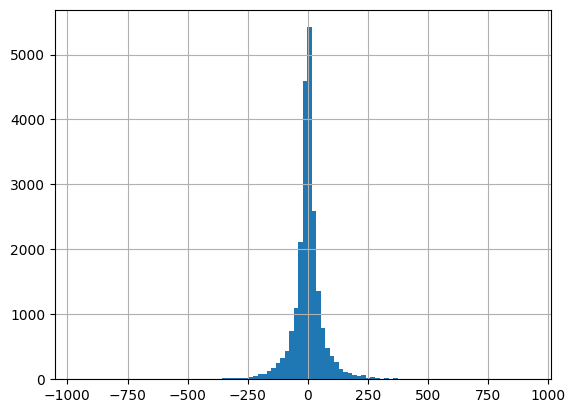

In [11]:
df['TSF'].hist(bins=100)